# Gluon Model Evaluation using `SoftmaxCrossEntropyLoss`

In [1]:
# Import necessary Libraries
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
import h5py
from sklearn.metrics import accuracy_score

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Datasets

In [2]:
# Import the Datasets
dataset = h5py.File('datasets/datasets.h5', 'r')
train_set_x_orig = np.array(dataset['train_set_x'][:])
train_set_y_orig = np.array(dataset['train_set_y'][:])
test_set_x_orig = np.array(dataset['test_set_x'][:])
test_set_y_orig = np.array(dataset['test_set_y'][:])

In [3]:
# View Training Dataset
print("Training Data Dimensions: {}".format(train_set_x_orig.shape))
print("No. Examples: {}".format(train_set_x_orig.reshape((-1, 12288)).shape[0]))
print("No. Inputs: {}".format(train_set_x_orig.reshape((-1, 12288)).shape[1]))

Training Data Dimensions: (209, 64, 64, 3)
No. Examples: 209
No. Inputs: 12288


In [4]:
# View Testing Dataset
print("Testing Data Dimensions: {}".format(test_set_x_orig.shape))
print("No. Examples: {}".format(test_set_x_orig.reshape((-1, 12288)).shape[0]))
print("No. Inputs: {}".format(test_set_x_orig.reshape((-1, 12288)).shape[1]))

Testing Data Dimensions: (50, 64, 64, 3)
No. Examples: 50
No. Inputs: 12288


In [5]:
# Pre-process Data
def transform(x):
    v = x.reshape((x.shape[0], (x.shape[1] * x.shape[2]) * x.shape[3]))
    return v.astype(np.float32) / 255
train_data = transform(train_set_x_orig)
train_label = train_set_y_orig.astype(np.float32)
test_data = transform(test_set_x_orig)
test_label = test_set_y_orig.astype(np.float32)
print("Final Training Data Dimensions: {}".format(train_data.shape))
print("Final Testing Data Dimensions: {}".format(test_data.shape))

Final Training Data Dimensions: (209, 12288)
Final Testing Data Dimensions: (50, 12288)


### Neural Network Configuration

In [6]:
# Network Config
epochs = 2500
num_examples = train_data.shape[0]
batch_size = 64
lr = 0.0075

# Create Training and Test Data Iterator
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        train_data,
        train_label
    ),
    shuffle=True,
    batch_size=batch_size
)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        test_data,
        test_label
    ),
    shuffle=False,
    batch_size=batch_size
)

### Neural Network Model

In [7]:
# Network Model
model_ctx = mx.cpu()
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Dense(20, activation='relu'))
    net.add(gluon.nn.Dense(7, activation='relu'))
    net.add(gluon.nn.Dense(5, activation='relu'))
    net.add(gluon.nn.Dense(2, activation='relu'))
net.hybridize()

# Parameter Initialization
net.collect_params().initialize(mx.init.Xavier(magnitude=2.34))
#net.collect_params().initialize(mx.init.Xavier(magnitude=3.34))
#net.collect_params().initialize(mx.init.Normal(sigma=1.))
#net.collect_params().initialize(mx.init.Xavier(factor_type="in", rnd_type='gaussian', magnitude=2))
#net.collect_params().initialize(mx.init.MSRAPrelu())
# Optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
# Cross Entropy Loss Function
softmax_ce = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
# Evlauation metric
def eval_acc(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        #acc.reset()
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

### Model Training

In [9]:
# Training Loop
costs = []
for e in range(epochs):
    cumulative_loss = 0
    # Enumerate bacthes
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        # Record for calculating derivatives from forward pass
        with autograd.record():
            output = net(data)
            loss = softmax_ce(output, label)
            # Run backward pass
            loss.backward()
        # Next batch
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
    # Accuracy score (formatting for SageMaker HPO)    
    valid_accuracy = eval_acc(test_data, net)
    train_accuracy = eval_acc(train_data, net)
    costs.append(cumulative_loss/num_examples)
    if e % 100 == 0:
        print("Epoch{}; Loss = {}; Train-accuracy = {}; Validation-accuracy = {}"\
              .format(e,cumulative_loss/num_examples,train_accuracy,valid_accuracy))

Epoch0; Loss = 0.6716120186034572; Train-accuracy = 0.6555023923444976; Validation-accuracy = 0.34
Epoch100; Loss = 0.37092011054737145; Train-accuracy = 0.9473684210526315; Validation-accuracy = 0.58
Epoch200; Loss = 0.3535070784354324; Train-accuracy = 0.7511961722488039; Validation-accuracy = 0.38
Epoch300; Loss = 0.14651222662492233; Train-accuracy = 1.0; Validation-accuracy = 0.64
Epoch400; Loss = 0.10977441386172646; Train-accuracy = 1.0; Validation-accuracy = 0.62
Epoch500; Loss = 0.08713614997681249; Train-accuracy = 1.0; Validation-accuracy = 0.62
Epoch600; Loss = 0.0719801298739237; Train-accuracy = 1.0; Validation-accuracy = 0.6
Epoch700; Loss = 0.06039226083664233; Train-accuracy = 1.0; Validation-accuracy = 0.6
Epoch800; Loss = 0.05160868880851417; Train-accuracy = 1.0; Validation-accuracy = 0.6
Epoch900; Loss = 0.044592150660793174; Train-accuracy = 1.0; Validation-accuracy = 0.62
Epoch1000; Loss = 0.03862522435530521; Train-accuracy = 1.0; Validation-accuracy = 0.62
Epoc

### Training Analysis

Final Scaore:
Epoch2499; Loss = 0.005295923059922086
Validation-ccuracy 60.0%


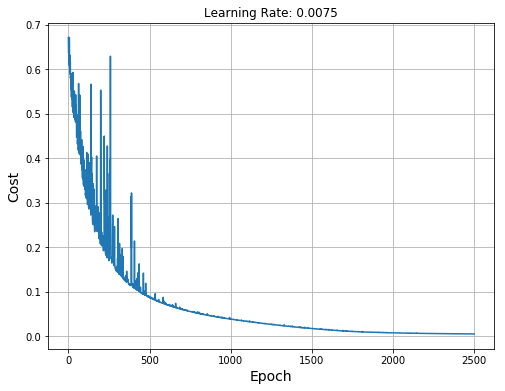

In [10]:
# Final Score
final_accuracy = eval_acc(test_data, net)
print("Final Scaore:\nEpoch{}; Loss = {}\nValidation-ccuracy {}%".format(
    e,cumulative_loss/num_examples, final_accuracy*100)
)

# Plot the convergence of the cost function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(num=None,figsize=(8, 6))
plt.plot(costs)
plt.grid(True, which="both")
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.title("Learning Rate: " + str(lr))
plt.show;

### Predict on Unseen Data

In [11]:
# Predict Funciton
def predict(image, net):
    data = nd.array(image).as_in_context(model_ctx)
    output = net(data)
    prediction = nd.argmax(output, axis=1)
    return prediction

#### Grumpy Cat

y = 1
The trained model predicts a "cat" picture.


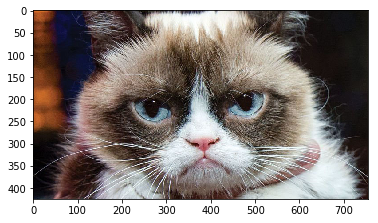

In [12]:
# Display and predict against grumpy cat image
from skimage import transform
classes = ['non-cat', 'cat']
my_image = "grumpy_cat.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = int(np.squeeze(predict(image, net).asnumpy()[0]))
my_predicted_image

# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(my_predicted_image) + \
       "\nThe trained model predicts a \"" + \
       str(classes[my_predicted_image]) +  "\" picture.")

#### Gargouille

y = 0
The trained model predicts a "non-cat" picture.


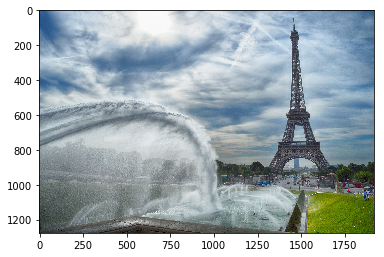

In [13]:
# Display and predict against the my image
my_image = "my_image.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = int(np.squeeze(predict(image, net).asnumpy()[0]))
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       str(classes[my_predicted_image]) +  "\" picture.")

### Save the Model and Optmized Parameters

In [14]:
# Create aplaceholder
z = net(mx.sym.var('data'))

# Save the model
z.save('model.json')

# Save the Optimized Parameters
net.collect_params().save('model.params')

### Load the Model and Test against different images

In [15]:
symbol = mx.sym.load('model.json')
outputs = mx.sym.sigmoid(data=symbol, name='sigmoid_label')
inputs = mx.sym.var('data')
param_dict = gluon.ParameterDict('model_')
model = gluon.SymbolBlock(outputs, inputs, param_dict)
model.load_params('model.params', ctx=model_ctx)

y = 1
The trained model predicts a "cat" picture.


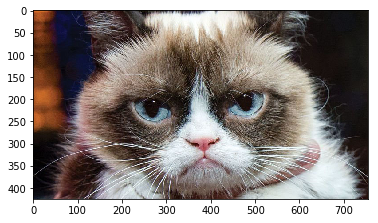

In [16]:
# Display and predict against grumpy cat image
my_image = "grumpy_cat.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = int(np.squeeze(predict(image, model).asnumpy()[0]))
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[my_predicted_image] +  "\" picture.")

y = 0
The trained model predicts a "non-cat" picture.


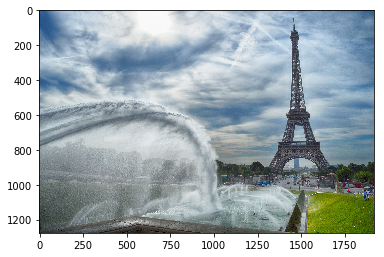

In [17]:
# Display and predict against the my_image
my_image = "my_image.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = int(np.squeeze(predict(image, net).asnumpy()[0]))
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[my_predicted_image] +  "\" picture.")

y = 1
The trained model predicts a "cat" picture.


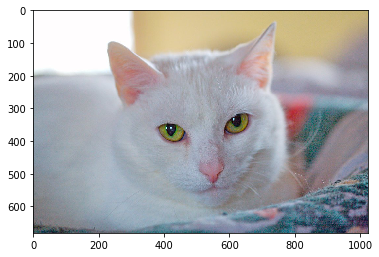

In [18]:
# Display and predict against the my_image 2
my_image = "my_image2.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = int(np.squeeze(predict(image, net).asnumpy()[0]))
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[my_predicted_image] +  "\" picture.")

y = 1
The trained model predicts a "cat" picture.


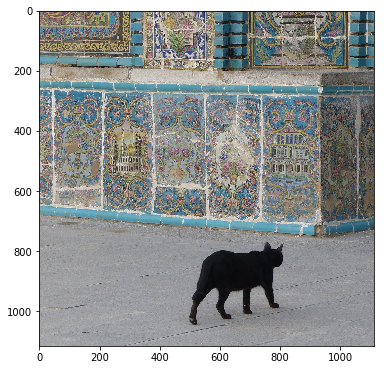

In [19]:
# Display and predict against the cat in iran
my_image = "cat_in_iran.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = int(np.squeeze(predict(image, net).asnumpy()[0]))
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[my_predicted_image] +  "\" picture.")

y = 0
The trained model predicts a "non-cat" picture.


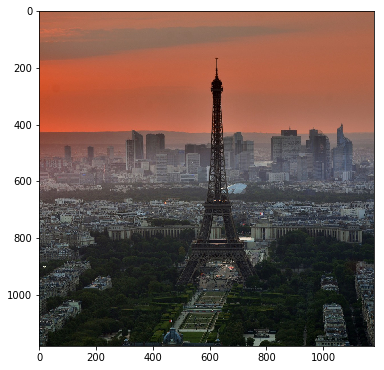

In [20]:
# Display and predict against the mla_defense
my_image = "la_defense.jpeg"
#y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
# Run the model against the image
my_predicted_image = int(np.squeeze(predict(image, net).asnumpy()[0]))
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[my_predicted_image] +  "\" picture.")